In [1]:
import json
import numpy as np
import pandas as pd
import re
import unicodedata
import string
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
# file = json.loads(open("dev-v2.0.json").read())
def read_squad_json(file):
    # read json file
    file = json.loads(open(file).read())
    #get context column and questions column
    context_questions = pd.json_normalize(file,['data','paragraphs'])
    #repeat context column for each question
    idx = np.repeat(context_questions['context'].values, context_questions.qas.str.len())
    #separate question and answer columns
    dataframe = pd.json_normalize(file,record_path=['data','paragraphs','qas'])
    #add context to each question
    dataframe['context'] = idx
    return dataframe
data = read_squad_json("train-v2.0.json")
def get_text(row):
    answer = ''
    plausible_answers =''
    if row['answers']:
        answer = row['answers'][0]['text']
    if row['plausible_answers']:
        plausible_answers= row['plausible_answers'][0]['text']
    return answer +plausible_answers
def answer_as_text(dataframe):
    dataframe['plausible_answers'].fillna('',inplace=True)
    dataframe['answer_text'] = dataframe.apply(get_text,axis=1)
    dataframe['answer_text'] = 'sss '+ dataframe['answer_text'] + ' eee'
    return dataframe
data = answer_as_text(data)[['question','context','answer_text']]


def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))#'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def lower_case(text):
    return text.lower()
def remove_non_english(text):#remove non ascci word
    return unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
def remove_links(text):
    return re.sub(r'https?://\S+','',text)
def remove_whitespaces(text):
    return text.strip()

def clean_text(text):
    return remove_punc(lower_case(remove_non_english((remove_links(text)))))

data['question'] = data['question'].apply(clean_text)
data['context'] = data['context'].apply(clean_text)
data['answer_text'] = data['answer_text'].apply(clean_text)

data['q_c']='CLS '+data['question']+' SEP '+data['context']

pd.to_pickle(data,'data.pkl')


--2022-08-13 23:31:56--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2022-08-13 23:32:00 (377 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



# import libraries

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.data import Dataset
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
import typing


In [3]:
MAX_CONTEXT = 200
MAX_ANSWER = 10
MAX_VOC_SIZE = 20000
BATCH_SIZE = 128

# word vector embedding size
EMBEDDING_SIZE = 256
# state size of LSTM
STATE_SIZE = 1024


# load pickle data

In [4]:
data = pd.read_pickle("data.pkl")


In [5]:
data.head(1)


,question,context,answer_text,q_c
0,when did beyonce start becoming popular,beyonce giselle knowlescarter bijnse beeyonsay...,sss in the late 1990s eee,CLS when did beyonce start becoming popular SE...


In [6]:
data['q_c'].iloc[0]

'CLS when did beyonce start becoming popular SEP beyonce giselle knowlescarter bijnse beeyonsay born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destinys child managed by her father mathew knowles the group became one of the worlds bestselling girl groups of all time their hiatus saw the release of beyonces debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy'

# build text vectorizer


In [7]:
input_tokenizer = TextVectorization(
    standardize=None, output_sequence_length=MAX_CONTEXT, max_tokens=MAX_VOC_SIZE
)
output_tokenizer = TextVectorization(
    standardize=None, output_sequence_length=MAX_ANSWER, max_tokens=MAX_VOC_SIZE
)


In [8]:
input_tokenizer.adapt(data["q_c"])
output_tokenizer.adapt(data["answer_text"])


# create dataset iterator

In [9]:
dataset = Dataset.from_tensor_slices((data["q_c"], data["answer_text"]))
dataset = dataset.batch(BATCH_SIZE)

# train = dataset.

In [10]:
dataset.as_numpy_iterator().next()[0].shape

(128,)

In [11]:
# example_input_batch batch of sentences
# example_tokens batch of tokens (sequences of words) (64, 21)
example_tokens = input_tokenizer(dataset.as_numpy_iterator().next()[0])
example_tokens[:3, :10]


<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  12,   49,   46,  759,  710, 1042,  306,   11,  759,    1],
       [  12,   20,  196,   46,  759, 3076,    5,   49,  209,   10],
       [  12,   49,   46,  759, 2186, 6115,  953,    4,  212,    7]])>

In [12]:
input_vocab = np.array(input_tokenizer.get_vocabulary())

tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'CLS when did beyonce start becoming popular SEP beyonce [UNK] [UNK] [UNK] [UNK] born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb [UNK] destinys child managed by her father mathew knowles the group became one of the worlds bestselling girl groups of all time their hiatus saw the release of beyonces debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy                                                                                   '

### Encoder

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super().__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.input_vocab_size, embedding_dim
        )  # ('batch_size', 'max_tokens in sentence', 'word vector size')

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            # Return the sequence and state
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    # override call method
    # The call method runs the model
    def call(self, tokens, state=None):
        """
        tokens: input sequence in shape (batch_size, sequence_length) **question_context**
        state: initial state of the RNN GRU layer
        output:
            output of the GRU layer in shape (batch_size, sequence_length, units)
            state of the GRU layer in shape (batch_size, units)

        """
        vectors = self.embedding(
            tokens
        )  # take the token and return the empedding vector

        output, state = self.gru(
            vectors, initial_state=state
        )  # pass the embedding vector to the GRU layer

        return output, state


### Attention Layer

In [14]:
# addaptive attention layer
# tanh(w1@ encoder heddin state + w2 @ decoder heddin state)
# will create two dense layer  as w1,w2


class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        """query  :encoder heddin state
        value :decoder heddin state This Will be the output of the encoder.
        mask :mask of the decoder heddin state
        output:
            context vector of shape (batch_size, query_seq_length, units)
            attention weights of shape  (batch_size, query_seq_length, value_seq_length)
        """
        # W1@ht
        w1_query = self.W1(query)

        # W2@hs
        w2_key = self.W2(value)

        query_mask = tf.ones(
            tf.shape(query)[:-1], dtype=bool
        )  # [batch_size, query]. output will be zero at the positions where mask==False
        value_mask = mask  # [batch_size, value] output will be zero at the positions where mask==False

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )

        return context_vector, attention_weights


In [15]:
# defin decoder input and output
class DecoderInput(typing.NamedTuple):
    new_tokens: typing.Any
    enc_output: typing.Any
    mask: typing.Any


class DecoderOutput(typing.NamedTuple):
    logits: typing.Any
    attention_weights: typing.Any


In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super().__init__()
        """
    output_vocab_size: size of the output vocabulary
    embedding_dim: size of the embedding vector
    dec_units: size of the hidden state of the GRU layer
    """
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size, embedding_dim
        )

        # The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

        # The RNN output will be the query for the attention layer.
        self.attention = Attention(self.dec_units)

        # context and decoder output will be combined to create the final output.
        self.Wc = tf.keras.layers.Dense(
            dec_units, activation=tf.math.tanh, use_bias=False
        )

        # produces the logits for each output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

    def call(
        self, inputs: DecoderInput, state=None
    ) -> typing.Tuple[DecoderOutput, tf.Tensor]:
        """
        inputs:
            new_tokens: shape (batch_size, 1)
            enc_output: shape (batch_size, sequence_length, hidden_size)
            mask: shape (batch_size, sequence_length)
        output:
            logits: shape  (batch_size, t, output_vocab_size)
            attention_weights: shape (batch_size, 1, sequence_length)
            state: shape (batch_size, hidden_size)
        """

        vectors = self.embedding(
            inputs.new_tokens
        )  # shape (batch_size, 1, embedding_dim)

        #  Process one step with the RNN
        rnn_output, state = self.gru(
            vectors, initial_state=state
        )  # (64, 1, 1024) (batch, words, units)

        # Use the RNN output as the query for the attention over the encoder output
        context_vector, attention_weights = self.attention(
            query=rnn_output, value=inputs.enc_output, mask=inputs.mask
        )

        # Join the context_vector and rnn_output
        context_and_rnn_output = tf.concat(
            [context_vector, rnn_output], axis=-1
        )  # shape: (batch t, value_units + query_units)

        # at = tanh(Wc@[ct; ht])` #ct: context_vector, ht: rnn_output
        attention_vector = self.Wc(context_and_rnn_output)

        # Generate logit predictions: ('batch', 't', 'output_vocab_size')
        logits = self.fc(attention_vector)

        return DecoderOutput(logits, attention_weights), state


## Training

In [17]:
# loss function
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = "masked_loss"
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction="none"
        )

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)


### train model

In [18]:
class TrainTranslator(tf.keras.Model):
    def __init__(
        self,
        embedding_dim,
        units,
        input_tokenizer_opject,
        output_tokenizer_opject,
        use_tf_function=True,
    ):
        super().__init__()
        # Build the encoder and decoder
        self.encoder = Encoder(
            input_tokenizer_opject.vocabulary_size(), embedding_dim, units
        )
        self.decoder = Decoder(
            output_tokenizer_opject.vocabulary_size(), embedding_dim, units
        )

        self.input_tokenizer_opject = input_tokenizer_opject
        self.output_tokenizer_opject = output_tokenizer_opject
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    def _preprocess(self, input_text, target_text):
        # Convert the text to token IDs
        input_tokens = self.input_tokenizer_opject(input_text)
        target_tokens = self.output_tokenizer_opject(target_text)

        # Convert IDs to masks.
        input_mask = input_tokens != 0

        target_mask = target_tokens != 0

        return input_tokens, input_mask, target_tokens, target_mask

    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(
            input_text, target_text
        )

        max_target_length = tf.shape(target_tokens)[1]  # number of output tokens

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of
            # units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length - 1):
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t : t + 2]
                step_loss, dec_state,y_pred = self._loop_step(
                    new_tokens, input_mask, enc_output, dec_state
                )
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Compute gradients
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, variables))
        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(new_tokens[:, 1:2], y_pred)

        # Return a dict mapping metric names to current value
        result = {"batch_loss": average_loss}
        result.update({m.name: m.result() for m in self.metrics})
        return result

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):

        input_token, target_token = (
            new_tokens[:, 0:1],
            new_tokens[:, 1:2],
        )  # first token is the input token, second token is the target token

        # Run the decoder one step.
        decoder_input = DecoderInput(
            new_tokens=input_token, enc_output=enc_output, mask=input_mask
        )

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # self.loss returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(
            y, y_pred
        )  # y: target_token (batch, 1), y_pred: logits (batch, output_vocab_size)

        return step_loss, dec_state,y_pred

    @tf.function(
        input_signature=[
            [
                tf.TensorSpec(dtype=tf.string, shape=[None]),
                tf.TensorSpec(dtype=tf.string, shape=[None]),
            ]
        ]
    )
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)


In [19]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs("batch_loss")


In [20]:
train_translator = TrainTranslator(
    EMBEDDING_SIZE,
    STATE_SIZE,
    input_tokenizer_opject=input_tokenizer,
    output_tokenizer_opject=output_tokenizer,
)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(), loss=MaskedLoss(), metrics=[SparseCategoricalAccuracy()]
)


In [21]:
history = train_translator.fit(dataset, epochs=5, callbacks=[batch_loss])


Epoch 1/5
1019/1019 [==============================] - 982s 957ms/step - batch_loss: 5.4124 - sparse_categorical_accuracy: 0.0191
Epoch 2/5
1019/1019 [==============================] - 974s 956ms/step - batch_loss: 4.9016 - sparse_categorical_accuracy: 0.0206
Epoch 3/5
1019/1019 [==============================] - 976s 958ms/step - batch_loss: 4.5422 - sparse_categorical_accuracy: 0.0210
Epoch 4/5
1019/1019 [==============================] - 966s 948ms/step - batch_loss: 4.4570 - sparse_categorical_accuracy: 0.0217
Epoch 5/5
1019/1019 [==============================] - 965s 947ms/step - batch_loss: 4.2574 - sparse_categorical_accuracy: 0.0222


Text(0, 0.5, 'CE/token')

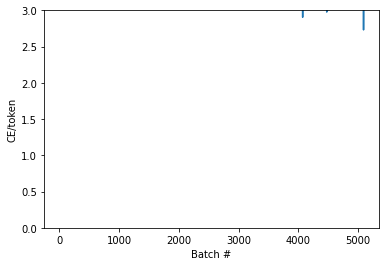

In [27]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [28]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor,
                output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', 'sss','CLS','SEP']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('sss'))
        self.end_token = index_from_string(tf.constant('eee'))
    def tokens_to_text(self, result_tokens):

        result_text_tokens = self.output_token_string_from_index(result_tokens)

        result_text = tf.strings.reduce_join(result_text_tokens,
                                            axis=1, separator=' ')

        result_text = tf.strings.strip(result_text)
        return result_text
    def sample(self, logits, temperature):

        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]#exlpand dimantion converet shape convert(5000,) to (1, 1, 5000)

        print(token_mask.shape)
        # Set the logits for all masked tokens to -inf, so they are never chosen.
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                                num_samples=1)
        return new_tokens

    def translate(self,input_text, *,max_length=10,return_attention=True,temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)# add start word foe eac sentence in batch

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                        enc_output=enc_output,
                                        mask=(input_tokens!=0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state) #dec_result : (logits,attention_weights)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done` done = 0
            done = done | (new_tokens == self.end_token) 
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done): #if there running excuation or all sentence in that word = 0 
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate(self, input_text):
        return self.translate(input_text)   

In [29]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_tokenizer,
    output_text_processor=output_tokenizer,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [42]:
%%time
input_text = tf.constant([
    # 'hace mucho frio aqui.', # "It's really cold here."
    # 'Esta es mi vida.', # "This is my life.""
    data['q_c'].iloc[0],
    data['q_c'].iloc[0]
    # data['answer_text'].iloc[0]
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

(1, 1, 20000)
(1, 1, 20000)
(1, 1, 20000)
a 1960s
may 2015

CPU times: user 74.3 ms, sys: 959 µs, total: 75.3 ms
Wall time: 77.3 ms


In [43]:
data['q_c'].iloc[0]

'CLS when did beyonce start becoming popular SEP beyonce giselle knowlescarter bijnse beeyonsay born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destinys child managed by her father mathew knowles the group became one of the worlds bestselling girl groups of all time their hiatus saw the release of beyonces debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy'

In [33]:
data['answer_text'].iloc[0]

'sss in the late 1990s eee'